In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os 

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes
from amfe.units import convert




Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using python in global path


In [2]:
mesh_folder = '/home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes'
msh_name = r'3D_safran_tet4_blade_9111_nodes_with_named_selections.inp'
msh_file = os.path.join(mesh_folder,msh_name)
m = amfe.Mesh()
m.import_inp(msh_file,1.0E3)

*************************************************************

Loading Abaqus-mesh from /home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes/3D_safran_tet4_blade_9111_nodes_with_named_selections.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh /home/mlid150/Documents/Demonstrator/Safran Demonstrator/Meshes/3D_safran_tet4_blade_9111_nodes_with_named_selections.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


In [3]:
from pyfeti import utils
utils.save_object(m,'blade.pkl')

<IPython.core.display.Javascript object>


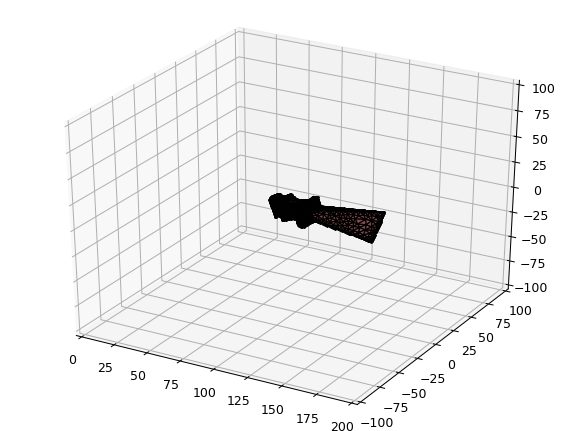

(-100, 100)

In [4]:
ax1 = amfe.plot3Dmesh(m)
#pltmesh.show(plot_nodes=False)
vlim=np.array([-100,100])
ax1.set_xlim(np.array([-0,200]))
ax1.set_ylim(vlim)
ax1.set_zlim(vlim)
#pltmesh.set_equal_axis_lim(vlim)

In [5]:
print(m.get_elem_types())
print(m.get_phys_group_types())

{'Tri3', 'Tet4'}
{'BLADE_1_1_SOLID_ELSET', 'BLADE_1_7_SOLID_ELSET', 'BLADE_1_3_SOLID_ELSET', 'FORCE_ELSET', 'BLADE_1_3_ELSET', 'BLADE_1_1_ELSET', 'BLADE_1_5_ELSET', 'BLADE_1_5_SOLID_ELSET', 'FIXED_ELSET', 'BLADE_1_4_ELSET', 'BLADE_1_7_ELSET', 'BLADE_1_2_SOLID_ELSET', 'BLADE_1_4_SOLID_ELSET', 'BLADE_1_6_SOLID_ELSET', 'BLADE_1_6_ELSET', 'BLADE_1_2_ELSET'}


In [6]:
map_string = lambda  i : 'BLADE_1_%i_SOLID_ELSET' %i

new_tag_name = 'Blade'
# rename solid components

for i in range(1,8):
    m.change_tag_in_eldf('phys_group',map_string(i),new_tag_name)


In [7]:
print(m.get_phys_group_types())

{'BLADE_1_6_ELSET', 'FORCE_ELSET', 'BLADE_1_3_ELSET', 'BLADE_1_1_ELSET', 'BLADE_1_5_ELSET', 'FIXED_ELSET', 'BLADE_1_4_ELSET', 'BLADE_1_7_ELSET', 'Blade', 'BLADE_1_2_ELSET'}


In [8]:
m.split_in_groups()  
blade = m.get_submesh('phys_group',new_tag_name)

In [9]:
node_target = np.array([0.143,1.15E-3,-6.78E-5])*1.0E3

def get_closer_node_id(node_target):
    diff = m.nodes - node_target
    ed = np.sqrt(np.diag(diff@diff.T))
    return np.argmin(ed)

def dofs_from_node_id_direction(node_edf, node_id, direction):
    
    row = node_edf.iloc[node_id]
    if direction in row:
        return row[direction]
    else:
        raise ValueError('Direciton %s not supported!' % direction)

node_id = get_closer_node_id(node_target)

<IPython.core.display.Javascript object>


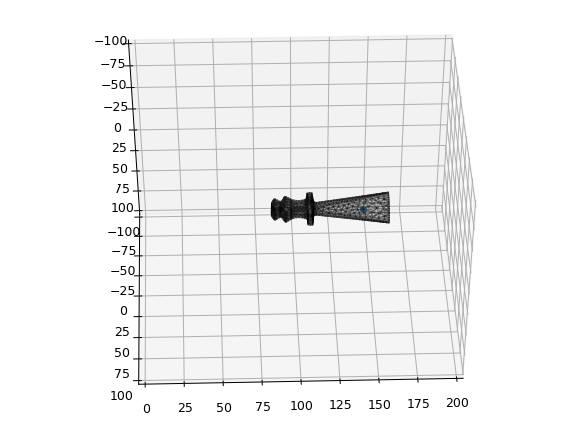

In [10]:
ax2 = amfe.plot3D_submesh(blade ,plot_nodes=False)
vlim=np.array([-100,100])
ax2.set_xlim(np.array([-0,200]))
ax2.set_ylim(vlim)
ax2.set_zlim(vlim)

ax2.scatter(m.nodes[node_id][0],m.nodes[node_id][1],m.nodes[node_id][2])

In [11]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
rho = 7.85E-9 # ton/mm3
E = 2.10E5 # MPa = N/mm2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)
my_comp.set_domain(new_tag_name,my_material)
my_comp.apply_neumann_boundaries('FORCE_ELSET',1.0E3, direct=[0,1,0])
print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 4857 elements and 4434 dofs.
Time taken for preallocation: 0.27 seconds.
Number of nodes is equal to 1478


In [12]:
K, f_ = my_comp.assembly_class.assemble_k_and_f()
_, f = my_comp.assembly_class.assemble_k_and_f_neumann()

In [13]:
max(f)

1438.479856369171

In [14]:
min(f)

0.0

In [15]:
M = my_comp.assembly_class.assemble_m()

In [16]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
try:
    connectivity = []
    for _,item in m.el_df.iloc[:, m.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_comp.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m.el_df)


dofs_dict = s.selection_dict
dofs_dict.update({'excitation': OrderedSet([dofs_from_node_id_direction(id_map_df, node_id, 'y')])})

In [17]:
from pyfeti.src.linalg import Matrix
K_obj = Matrix(K,key_dict=s.selection_dict)
M_obj = Matrix(M,key_dict=s.selection_dict)

In [18]:
tag_for_fixed_bc = 'FIXED_ELSET'
K_obj.eliminate_by_identity(tag_for_fixed_bc,1.0E15)
M_obj.eliminate_by_identity(tag_for_fixed_bc,0.0)

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


<4434x4434 sparse matrix of type '<class 'numpy.float64'>'
	with 134298 stored elements in Compressed Sparse Row format>

In [19]:
B = s.build_B('excitation')

In [20]:
u = sparse.linalg.spsolve(K_obj.data,f)

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [21]:
B.dot(u)

array([26.47897152])

<IPython.core.display.Javascript object>


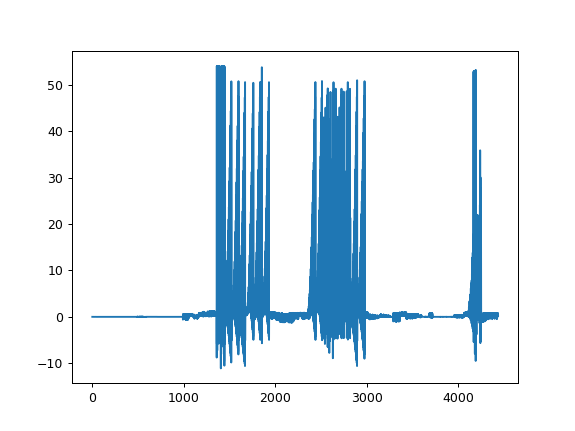

In [22]:
plt.figure()
plt.plot(u)

<IPython.core.display.Javascript object>


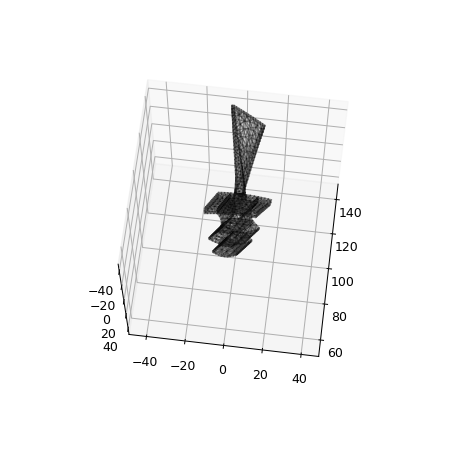

In [29]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

from pyfeti import utils
m1 = utils.load_object('blade.pkl')
fig1 = plt.figure(figsize=(5,5))
ax2 = fig1.add_subplot(1,1,1, projection='3d')
vlim=np.array([-100,100])*1.0E-3
ax2.set_xlim(np.array([-0,200])*1.0E-3)
ax2.set_ylim(vlim)
ax2.set_zlim(vlim)

def update(i=0):
  
    amfe.plot_deform_3D_mesh(m1,u,factor=i,ax=ax2,plot_nodes=False)
    vlim=np.array([-100,100])
    ax2.set_xlim(np.array([-0,200]))
    ax2.set_ylim(vlim)
    ax2.set_zlim(vlim)
    return ax2


#ani = FuncAnimation(fig1, update, frames=np.linspace(0, 1 ,10), blit=True, interval=1)  

update(0.1)

In [30]:
fig1.savefig('blade_safran.png')

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [24]:
from scipy import sparse

lu = sparse.linalg.splu(K_obj.data.tocsc())
D = sparse.linalg.LinearOperator(shape=K.shape,matvec=lambda x :lu.solve(M_obj.data.dot(x)))
eigval, eigvec = sparse.linalg.eigs(D,k=20)


In [25]:
omega = 1.0/np.sqrt(eigval.real)
freq = omega/(2.0*np.pi)
print(freq)

[ 2131.37572034  4271.97833478  9049.04526895 10623.0408552
 14470.62039504 21775.57740726 23402.06221637 25594.49641787
 28058.52555475 30678.95063179 36512.10183096 39460.39914915
 40134.61431428 46165.09211991 49749.2491971  50234.72246412
 53702.97966794 54569.80609248 60647.63100722 63639.0303711 ]


In [26]:
buildZ = lambda w,alpha=1.0E-6,beta=0.000 : -w**2*M_obj.data + K_obj.data + 1J*w*(alpha*K_obj.data+ beta*M_obj.data)

deltaf = 30
w_list = []
u_list = []
for i in range(1,200):
    w = i*deltaf*2.0*np.pi
    Z = buildZ(w)
    u = sparse.linalg.spsolve(Z,f)
    u_list.append(B.dot(u))
    w_list.append(w)

<IPython.core.display.Javascript object>


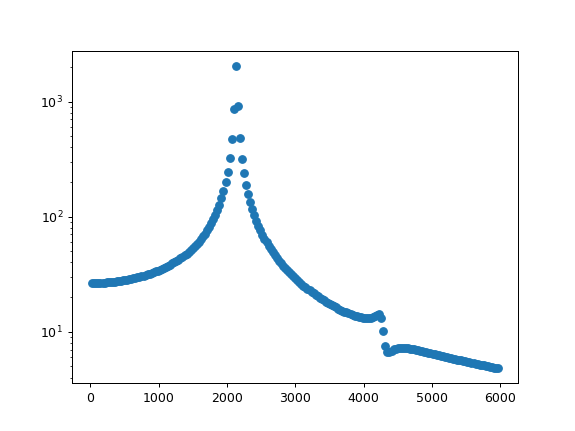

In [31]:
fig = plt.figure()
plt.plot(np.array(w_list)/(2.0*np.pi),np.abs(u_list),'o')
plt.yscale('log')


In [32]:
fig.savefig('frequency_response.png')